In [67]:
import sys
import os
sys.path.append(os.path.abspath("Final Design"))  # or use "final_design" if renamed

import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
from mislabelling import symmetric_noise, pair_noise, NNAR
from testing import *
from ucimlrepo import fetch_ucirepo
from sklearn.utils import Bunch
import matplotlib.pyplot as plt

In [68]:
def load_data():
    """
    Loads the dataset from local text files.

    Returns:
        A sklearn-style Bunch with:
            - data:     Feature matrix (n_samples, 2)
            - target:   Class labels (0 or 1)
            - feature_names, target_names, DESCR
    """

    data = fetch_ucirepo(id=45) 

    # data (as pandas dataframes) 
    X = data.data.features 
    y = data.data.targets.values.ravel()
    
    # metadata 
    print(data.metadata) 

    # Combine and shuffle
    np.random.seed(42)

    X, y = shuffle(X, y, random_state=42)
    
    sklearn_like = {
        'data': X.values,  # Convert DataFrame to ndarray
        'target': y,
        'feature_names': list(X.columns),
        'target_names': list(np.unique(y)),
        'DESCR': data.metadata.get('name', 'UCI Dataset')
    }

    return Bunch(**sklearn_like)

In [69]:
RESOLUTION = 20
TRIALS = 35
N_ESTIMATORS = 15
TEST_SIZE = 0.25
ITERATIONS = 10

FIG_SIZE = (5,4)
FONT_SIZE = 10
plt.rcParams["figure.figsize"] = FIG_SIZE  # width, height in inches

data = load_data()
print(data.data.shape)
print(data.target.shape)
data.target = data.target > 0
data.target = data.target.astype(int)

{'uci_id': 45, 'name': 'Heart Disease', 'repository_url': 'https://archive.ics.uci.edu/dataset/45/heart+disease', 'data_url': 'https://archive.ics.uci.edu/static/public/45/data.csv', 'abstract': '4 databases: Cleveland, Hungary, Switzerland, and the VA Long Beach', 'area': 'Health and Medicine', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 303, 'num_features': 13, 'feature_types': ['Categorical', 'Integer', 'Real'], 'demographics': ['Age', 'Sex'], 'target_col': ['num'], 'index_col': None, 'has_missing_values': 'yes', 'missing_values_symbol': 'NaN', 'year_of_dataset_creation': 1989, 'last_updated': 'Fri Nov 03 2023', 'dataset_doi': '10.24432/C52P4X', 'creators': ['Andras Janosi', 'William Steinbrunn', 'Matthias Pfisterer', 'Robert Detrano'], 'intro_paper': {'ID': 231, 'type': 'NATIVE', 'title': 'International application of a new probability algorithm for the diagnosis of coronary artery disease.', 'authors': 'R. Detrano, A. Jánosi, W. Steinbrunn, M

In [70]:
accuracies_all, auc_all, relabelling_f1_all, relabelling_acc_all, x_axis = run_noise_level_experiment(
    data, RandomForestClassifier, symmetric_noise,
    n_estimators=N_ESTIMATORS, trials=TRIALS,
    resolution=RESOLUTION, test_size=TEST_SIZE, iterations=ITERATIONS
)

accuracies_boot, auc_boot, relabelling_f1_boot, relabelling_acc_boot, x_axis = run_noise_level_experiment(
    data, RandomForestClassifier, symmetric_noise,
    n_estimators=N_ESTIMATORS, trials=TRIALS,
    resolution=RESOLUTION, test_size=TEST_SIZE, iterations=ITERATIONS,
    control=False, bootstrapping=True
)

accuracies_all = np.concatenate([accuracies_all, accuracies_boot[:1]], axis=0)
auc_all = np.concatenate([auc_all, auc_boot[:1]], axis=0)
relabelling_f1_all = np.concatenate([relabelling_f1_all, relabelling_f1_boot[:1]], axis=0)
relabelling_acc_all = np.concatenate([relabelling_acc_all, relabelling_acc_boot[:1]], axis=0)


# Process results
accuracies_mean_base, accuracies_se_base = process_experiment_result(accuracies_all)
auc_mean, auc_se = process_experiment_result(auc_all)
relabelling_f1_success_base, relabelling_f1_se_base = process_experiment_result(relabelling_f1_all)
relabelling_acc_success_base, relabelling_acc_se_base = process_experiment_result(relabelling_acc_all)

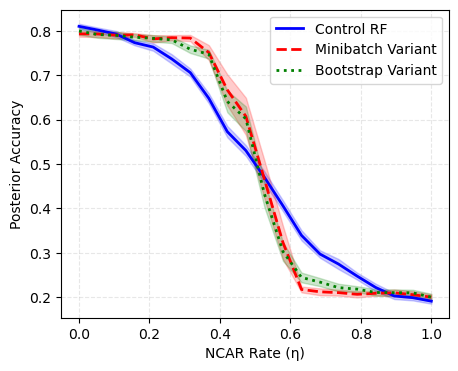

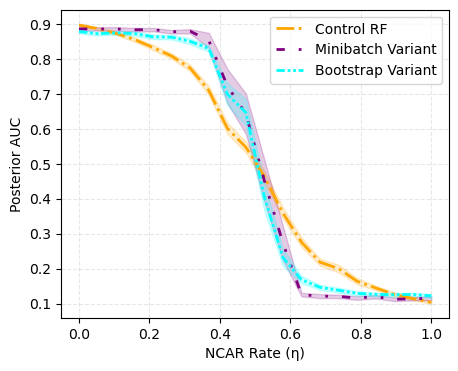

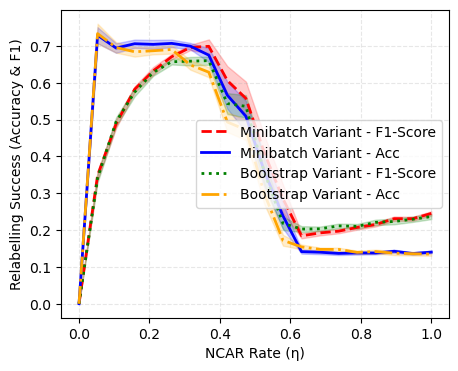

In [72]:
# Accuracy lines
plot_with_error_band(x_axis, accuracies_mean_base[1], accuracies_se_base[1], label="Control RF", color='blue', linestyle='-')
plot_with_error_band(x_axis, accuracies_mean_base[0], accuracies_se_base[0], label="Minibatch Variant", color='red', linestyle='--')
plot_with_error_band(x_axis, accuracies_mean_base[2], accuracies_se_base[2], label="Bootstrap Variant", color='green', linestyle=':')

plt.xlabel(fontsize=FONT_SIZE, xlabel = "NCAR Rate (η)")
plt.ylabel(fontsize=FONT_SIZE, ylabel = "Posterior Accuracy")
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.legend()
plt.grid(True)
plt.show()

plot_with_error_band(x_axis, auc_mean[1], auc_se[1], label="Control RF", color='orange', linestyle='-.')
plot_with_error_band(x_axis, auc_mean[0], auc_se[0], label="Minibatch Variant", color='purple', linestyle=(0, (3, 5, 1, 5, 1, 5)))
plot_with_error_band(x_axis, auc_mean[2], auc_se[2], label="Bootstrap Variant", color='cyan', linestyle=(0, (3, 1, 1, 1, 1, 1)))

plt.xlabel(fontsize=FONT_SIZE, xlabel = "NCAR Rate (η)")
plt.ylabel(fontsize=FONT_SIZE, ylabel = "Posterior AUC")
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.legend()
plt.grid(True)
plt.show()

plot_with_error_band(x_axis, relabelling_f1_success_base[0], relabelling_f1_se_base[0], label="Minibatch Variant - F1-Score", color='red', linestyle='--')
plot_with_error_band(x_axis, relabelling_acc_success_base[0], relabelling_acc_se_base[0], label="Minibatch Variant - Acc", color='blue')
plot_with_error_band(x_axis, relabelling_f1_success_base[1], relabelling_f1_se_base[1], label="Bootstrap Variant - F1-Score", color='green', linestyle=':')
plot_with_error_band(x_axis, relabelling_acc_success_base[1], relabelling_acc_se_base[1], label="Bootstrap Variant - Acc", color='orange', linestyle='-.')

plt.xlabel(fontsize=FONT_SIZE, xlabel = "NCAR Rate (η)")
plt.ylabel(fontsize=FONT_SIZE, ylabel = "Relabelling Success (Accuracy & F1)")
plt.xticks(fontsize=FONT_SIZE)
plt.yticks(fontsize=FONT_SIZE)
plt.legend()
plt.grid(True)
plt.show()